In [1]:
# Libraries

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Loading Air Transportation Network

In [10]:
USAL_TN_df=pd.read_csv('US Air Traffic TN/USAL_TN_monthly.txt', header=None, sep="\s+")
USAL_TN_df.columns=(['t','i','j'])

In [9]:
ordered_IDs = pd.read_csv('US Air Traffic TN/ordered_airport_ID.txt', header=None, sep="\s+")


In [11]:
# tranform data in series of nx graphs

iis=np.unique(USAL_TN_df['i'])
jjs=np.unique(USAL_TN_df['j'])
nodes=np.union1d(iis,jjs)
x=np.unique(USAL_TN_df['t'])
airlines_TN=[]

for t in range(len(x)):
    fr=USAL_TN_df[USAL_TN_df['t']==x[t]][['i','j']]
    gu=nx.from_pandas_edgelist(fr,'i','j')
    g=nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(gu.edges)
    g.remove_edges_from(nx.selfloop_edges(g))
    airlines_TN.append(g)

In [13]:
# Aggregated network

N=len(nodes)
AL_AGG=nx.Graph()
al_agg=np.zeros((N,N))
for go in airlines_TN:
    AL_AGG=nx.compose(AL_AGG,go)
    al_agg=al_agg+nx.to_numpy_matrix(go)

# Statistical properties of aggregated network

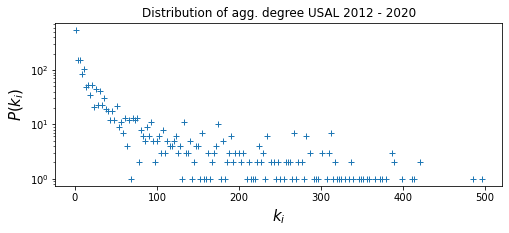

In [15]:
# Aggregate degree

agg_k=[fr[1] for fr in list(AL_AGG.degree()) ]

x,y=np.histogram(agg_k,bins=200)

fig=plt.figure(figsize=(8,3))
plt.semilogy(y[:-1],x,'+')
plt.title('Distribution of agg. degree USAL 2012 - 2020')
plt.xlabel('$k_i$',fontsize=15)
plt.ylabel('$P(k_i)$',fontsize=15)
plt.show()

In [37]:
ordered_k=np.sort(agg_k)
ordered_k[-3:]

array([422, 487, 498])

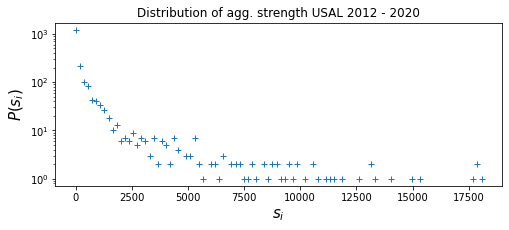

In [16]:
# Aggregate strength


s=np.sum(al_agg,axis=1)

x,y=np.histogram(s,bins=100)

fig=plt.figure(figsize=(8,3))
plt.semilogy(y[:-1],x,'+')
plt.title('Distribution of agg. strength USAL 2012 - 2020')
plt.xlabel('$s_i$',fontsize=15)
plt.ylabel('$P(s_i)$',fontsize=15)
plt.show()

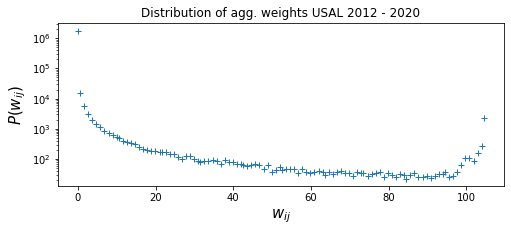

In [17]:
# Aggregate weights


w=np.array([al_agg[i,j] for i in range(N) for j in np.arange(i+1,N,1)])

x,y=np.histogram(w,bins=200)

fig=plt.figure(figsize=(8,3))
plt.semilogy(y[:-1],x,'+')
plt.title('Distribution of agg. weights USAL 2012 - 2020')
plt.xlabel('$w_{ij}$',fontsize=15)
plt.ylabel('$P(w_{ij})$',fontsize=15)
plt.show()

# Temporal Rich Club

In [31]:
# Function

def temporal_RC(Gt,AggG,k,delta,N,T,nodes):
    x=np.array([d[1] for d in AggG.degree()])
    set_k=set(nodes[np.where(x>k)[0]])
    vec_k=nodes[np.where(x>k)[0]]
    size_Sk=len(vec_k)
    M_s=np.zeros(T-delta)
    if size_Sk>3:
        for t in range(T-delta):
            g=Gt[t]
            neighs=[[] for h in range(size_Sk)]
            for node in range(size_Sk):
                deh=set(nx.neighbors(Gt[t],vec_k[node]))
                neighs[node]=np.array(list(set_k & deh))
            for D in range(delta):
                for n in range(size_Sk):
                    doh=set(nx.neighbors(Gt[t+D],vec_k[n]))
                    neighs[n]=np.array(list(set(neighs[n]) & doh))
            
            eps=[len(x) for x in neighs]
            M_s[t]=np.sum(eps)/float(size_Sk*(size_Sk-1))
      
        return np.max(M_s),M_s,size_Sk
    else:
        return 0,M_s,size_Sk

## $\epsilon_{>k}(t,\Delta)$ of $S_{>320}$ and $S_{>410}$

In [33]:
a,b,c = temporal_RC(airlines_TN,AL_AGG,320,1,np.shape(airlines_TN)[1],np.shape(airlines_TN)[0],nodes)

In [34]:
a1,b1,c1 = temporal_RC(airlines_TN,AL_AGG,410,1,np.shape(airlines_TN)[1],np.shape(airlines_TN)[0],nodes)

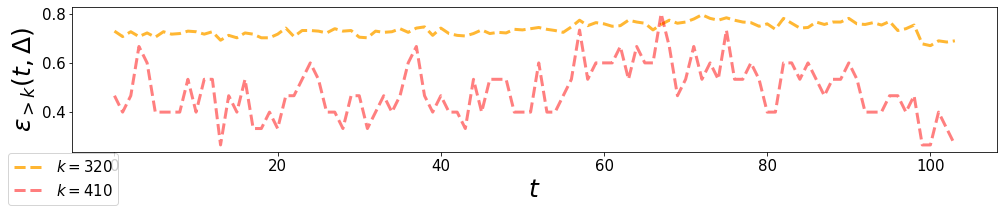

In [35]:


fig=plt.figure(figsize=(14,3))

plt.plot(b,'orange',label='$k=320$',alpha=0.8,linestyle='--',linewidth = 3)
plt.plot(b1,'r--',label='$k=410$',alpha=0.5,linewidth = 3)
plt.ylabel('$\epsilon_{>k}(t,\Delta)$',fontsize=25)
plt.xlabel('$t$',fontsize=25)
plt.tick_params(labelsize=15)

fig.legend(fontsize=15,loc='lower left')

plt.tight_layout()


# $k-\Delta$ diagram

In [ ]:
deltas=np.arange(1,105,1)
ks=np.arange(50,420,1)
RC_mat=np.zeros((len(deltas),len(ks)))
for delta in range(len(deltas)):
    print(delta)
    for k in range(len(ks)):
        RC_mat[delta,k]=temporal_RC(airlines_TN,AL_AGG,ks[k],deltas[delta],np.shape(airlines_TN)[1],np.shape(airlines_TN)[0],nodes)[0]


In [38]:
# Size of S_k as a function of k

agg_k=[fr[1] for fr in list(AL_AGG.degree()) ]

aggs=np.zeros(370)
for ki in range(370):
    aggs[ki]=len(np.where(np.array(agg_k)>ki+50)[0])

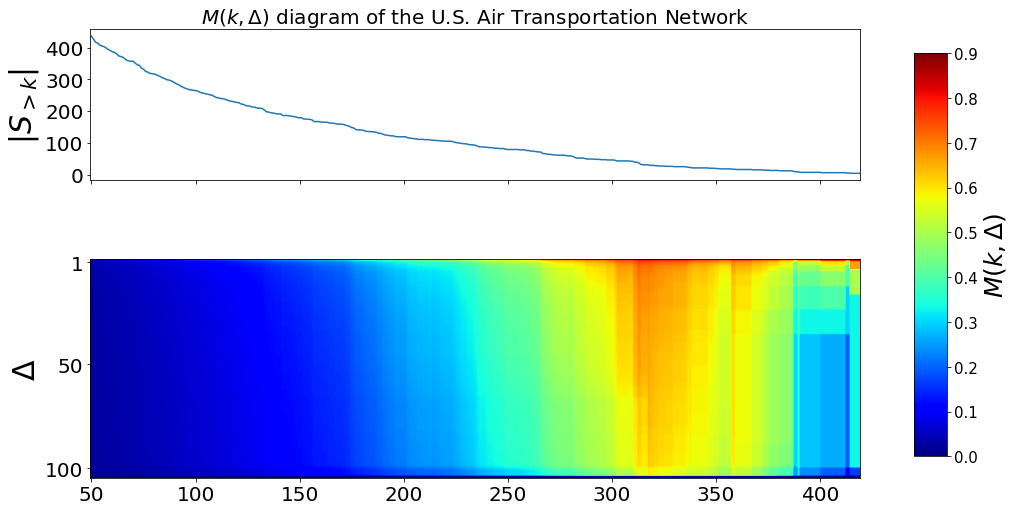

In [50]:

deltas=np.arange(1,103,1)
ks=np.arange(50,420,1)
ns = np.arange(0,max(aggs),100,dtype=int)

fig, (a2,a0) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.8,2]},figsize=(15,8),sharex=True)

a2.plot(np.arange(0,370,1),aggs)
a2.set_xticks(np.arange(0,370,20))
a2.set_xticklabels(ks[::20],fontsize=20)
a2.set_ylabel('$|S_{>k}|$',fontsize=30)
a2.set_yticks(ns)

a2.set_yticklabels(ns,fontsize=20)
a2.set_title(r"$M(k,\Delta)$ diagram of the U.S. Air Transportation Network",fontsize=20)


z_1=a0.imshow(RC_mat,cmap='jet',vmax=0.9,aspect=1)
a0.set_yticks([1,50,100])
a0.set_xticks(np.arange(0,370,50))
a0.set_ylabel(r'$\Delta$',fontsize=30)
a0.set_xticklabels(ks[::50],fontsize=20)
a0.set_yticklabels(deltas[[0,49,99]],fontsize=20)


plt.tight_layout()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.20, 0.03, 0.7])
cbar1=fig.colorbar(z_1,cax=cbar_ax)
cbar1.ax.tick_params(labelsize=15) 

cbar1.set_label(label=r'$M(k,\Delta)$',size=25)



plt.show()
